# Prompt Sensitivity Analysis for Memorization

이 노트북은 Memorized Prompt와 Unmemorized Prompt가 텍스트 입력의 미세한 변화(단어 순서, 단어 교체 등)에 대해 얼마나 민감하게 반응하는지 분석합니다.

**가설:**
Memorized Prompt는 모델이 과적합된 상태이므로 입력의 미세한 변화에도 생성 경로(Noise Prediction)가 급격하게 변할 것이다. 반면 Unmemorized Prompt는 일반적인 개념의 조합이므로 변화에 둔감할 것이다.

In [32]:
%cd /home/gpuadmin/cssin/init_noise_diffusion_memorization

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from diffusers import DDIMScheduler
from local_sd_pipeline import LocalStableDiffusionPipeline

# Set random seed
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

device = "cuda" if torch.cuda.is_available() else "cpu"
set_seed(42)

/home/gpuadmin/cssin/init_noise_diffusion_memorization


In [33]:
class AnalysisPipeline(LocalStableDiffusionPipeline):
    """
    Standard Pipeline을 상속받아, Denoising Loop 내부의 Noise Prediction 값을 캡처하는 파이프라인
    """
    @torch.no_grad()
    def __call__(
        self,
        prompt,
        num_inference_steps=50,
        guidance_scale=7.5,
        generator=None,
        **kwargs,
    ):
        device = self._execution_device
        do_classifier_free_guidance = True # Always calculate both for analysis

        # 2. Encode input prompt
        prompt_embeds = self._encode_prompt(
            prompt,
            device,
            1, 
            do_classifier_free_guidance,
            negative_prompt=None,
        )

        # 3. Timesteps
        self.scheduler.set_timesteps(num_inference_steps, device=device)
        timesteps = self.scheduler.timesteps

        # 4. Prepare latents
        latents = self.prepare_latents(
            1,
            self.unet.config.in_channels,
            self.unet.config.sample_size * self.vae_scale_factor,
            self.unet.config.sample_size * self.vae_scale_factor,
            prompt_embeds.dtype,
            device,
            generator,
            None,
        )

        analysis_data = {
            "timesteps": [],
            "cond_norm": [],
            "uncond_norm": [],
            "diff_norm": [],
        }

        for i, t in enumerate(timesteps):
            latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
            latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

            noise_pred = self.unet(
                latent_model_input,
                t,
                encoder_hidden_states=prompt_embeds,
                return_dict=False,
            )[0]

            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            
            norm_cond = torch.norm(noise_pred_text).item()
            norm_uncond = torch.norm(noise_pred_uncond).item()
            diff = noise_pred_text - noise_pred_uncond
            norm_diff = torch.norm(diff).item()
            
            analysis_data["timesteps"].append(t.item())
            analysis_data["cond_norm"].append(norm_cond)
            analysis_data["uncond_norm"].append(norm_uncond)
            analysis_data["diff_norm"].append(norm_diff)
            
            noise_pred = noise_pred_uncond + guidance_scale * diff
            latents = self.scheduler.step(noise_pred, t, latents, return_dict=False)[0]
        
        image = self.vae.decode(latents / self.vae.config.scaling_factor, return_dict=False)[0]
        image = self.image_processor.postprocess(image, output_type="pil")

        return image[0], analysis_data

In [34]:
class FirstStepAnalysisPipeline(LocalStableDiffusionPipeline):
    """
    첫 번째 Step의 Noise Prediction만 분석하고 종료하는 efficiently Pipeline
    """
    @torch.no_grad()
    def __call__(
        self,
        prompt,
        num_inference_steps=50,
        generator=None,
        **kwargs,
    ):
        device = self._execution_device
        # 1. Encode with CFG enabled
        prompt_embeds = self._encode_prompt(
            prompt, device, 1, True, negative_prompt=None
        )

        # 2. Get FIRST timestep only
        self.scheduler.set_timesteps(num_inference_steps, device=device)
        t = self.scheduler.timesteps[0] 

        # 3. Prepare latents (Random Noise)
        latents = self.prepare_latents(
            1,
            self.unet.config.in_channels,
            self.unet.config.sample_size * self.vae_scale_factor,
            self.unet.config.sample_size * self.vae_scale_factor,
            prompt_embeds.dtype,
            device,
            generator,
            None,
        )

        # 4. Predict Noise (Single Step)
        latent_model_input = torch.cat([latents] * 2) 
        latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

        noise_pred = self.unet(
            latent_model_input,
            t,
            encoder_hidden_states=prompt_embeds,
            return_dict=False,
        )[0]

        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        
        return {
            "cond": noise_pred_text.cpu(),
            "uncond": noise_pred_uncond.cpu()
        }

In [35]:
# Load Models
model_id = "CompVis/stable-diffusion-v1-4"
print(f"Loading model: {model_id}...")

pipe = AnalysisPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16 if device == "cuda" else torch.float32,
    safety_checker=None,
    requires_safety_checker=False
).to(device)
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)

# Share components for efficiency
pipe_single = FirstStepAnalysisPipeline(
    vae=pipe.vae,
    text_encoder=pipe.text_encoder,
    tokenizer=pipe.tokenizer,
    unet=pipe.unet,
    scheduler=pipe.scheduler,
    safety_checker=None,
    feature_extractor=pipe.feature_extractor,
    requires_safety_checker=False
).to(device)

print("Model loaded.")

Loading model: CompVis/stable-diffusion-v1-4...


/home/gpuadmin/cssin/init_noise_diffusion_memorization/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Model loaded.


In [36]:
# Load Prompts
try:
    df = pd.read_csv('prompts/memorized_laion_prompts.csv', sep=';')
    memorized_prompts = df['Caption'].tolist()
    print(f"Loaded {len(memorized_prompts)} memorized prompts.")
except FileNotFoundError:
    print("Memorized prompts file not found. Using default example.")
    memorized_prompts = [
        "As Punisher Joins Daredevil Season Two, Who Will the New Villain Be?"
    ]

unmemorized_prompts = [
    "A beautiful sunset over a calm ocean with a sailboat in the distance",
    "A cute cat sitting on a windowsill looking at the rain",
    "Modern office interior with large windows and plants",
    "A red apple sitting on a rustic wooden table",
    "A busy city street with people walking and cars driving",
    "A dense forest with tall pine trees and mossy ground",
    "A bouquet of colorful flowers in a glass vase",
    "A vintage bicycle parked against a brick wall",
    "A peaceful lake reflecting the surrounding mountains",
    "A plate of delicious pasta with tomato sauce and basil",
    "A fluffy white cloud in a bright blue sky",
    "A cozy living room with a fireplace and a book",
    "A majestic eagle flying high above the canyons",
    "A stack of old books on a dusty shelf",
    "A colorful hot air balloon floating in the air",
    "A basket of fresh fruit including oranges and bananas",
    "A snow-covered cabin in the woods during winter",
    "A sandy beach with palm trees and turquoise water",
    "A futuristic cityscape with flying cars and neon lights",
    "A cup of hot chocolate with marshmallows",
    "A pair of running shoes on a running track",
    "A garden full of blooming roses and tulips",
    "A train traveling through a scenic countryside",
    "A close-up of a butterfly on a sunflower",
    "A wooden bridge crossing a small stream",
    "A starry night sky with a full moon",
    "A guitar leaning against an amplifier",
    "A delicious pizza with pepperoni and cheese",
    "A waterfall cascading down rocky cliffs",
    "A group of friends laughing and talking at a cafe",
    "A lighthouse standing tall on a rocky shore",
    "A field of wheat swaying in the wind",
    "A modern kitchen with stainless steel appliances",
    "A sleeping puppy on a soft blanket",
    "A vibrant market stall selling spices and textiles",
    "A winding road going up a steep hill",
    "A sailboat reflected in the calm water at dawn",
    "A castle on a hill overlooking a village",
    "A robot exploring a mars-like landscape",
    "A bowl of fresh salad with various vegetables",
    "A ancient ruin covered in vines and moss",
    "A surfer riding a big wave in the ocean",
    "A snowy owl perched on a branch",
    "A classic car show with shiny vintage vehicles",
    "A tranquil zen garden with sand and rocks",
    "A baker arranging pastries in a display case",
    "A hiker standing on a mountain summit",
    "A watercolor painting of a landscape",
    "A glass of red wine and cheese on a board",
    "A cozy bedroom with soft lighting and pillows"
]

Loaded 500 memorized prompts.


In [37]:
def permute_words(text):
    words = text.split()
    random.shuffle(words)
    return " ".join(words)

def analyze_vectors(vec_base, vec_target):
    v1 = vec_base.flatten().float()
    v2 = vec_target.flatten().float()
    
    # 1. Cosine Similarity
    cos_sim = torch.nn.functional.cosine_similarity(v1.unsqueeze(0), v2.unsqueeze(0)).item()
    
    # 2. L2 Norm Difference (Euclidean)
    l2_diff = torch.norm(v1 - v2, p=2).item()
    
    # 3. L1 Norm Difference (Manhattan)
    l1_diff = torch.norm(v1 - v2, p=1).item()
    
    # 4. Max Absolute Difference (Infinity Norm)
    max_diff = torch.max(torch.abs(v1 - v2)).item()
    
    return cos_sim, l2_diff, l1_diff, max_diff

In [38]:
def run_single_step_experiment(base_prompt, variations, tag="SingleStep"):
    seed = 9999
    print(f"[{tag}] Analysis Start...")
    
    # 1. Compute Base (Fixed Seed)
    gen = torch.Generator(device=device).manual_seed(seed)
    res_base = pipe_single(base_prompt, generator=gen)
    base_uncond = res_base["uncond"]
    base_cond = res_base["cond"]
    
    metrics = {
        "uncond_check_l2": [], 
        "cond_cos_sim": [],
        "cond_l2_diff": [],
        "cond_l1_diff": [],
        "cond_max_diff": []
    }
    
    for i, var_prompt in enumerate(variations):
        # 2. Compute Variation (SAME Seed)
        gen = torch.Generator(device=device).manual_seed(seed)
        res_var = pipe_single(var_prompt, generator=gen)
        
        # A. Verification: Uncond Noise Consistency
        uncond_diff = torch.norm(base_uncond - res_var["uncond"]).item()
        metrics["uncond_check_l2"].append(uncond_diff)
        
        # B. Analyze Conditional Noise Change
        cos, l2, l1, max_d = analyze_vectors(base_uncond, res_var["cond"])
        metrics["cond_cos_sim"].append(cos)
        metrics["cond_l2_diff"].append(l2)
        metrics["cond_l1_diff"].append(l1)
        metrics["cond_max_diff"].append(max_d)
        
    # Check Consistency
    max_err = max(metrics["uncond_check_l2"])
    if max_err > 1e-4:
        print(f"  [WARNING] Uncond noise changed! Max diff: {max_err:.6f}")
    else:
        print(f"  [OK] Uncond noise stable. Max diff: {max_err:.6e}")
        
    return metrics

## 100 Trials Analysis: Memorized vs Unmemorized

In [39]:
# Setup
N_TRIALS = 100
mem_prompt = memorized_prompts[0]
unmem_prompt = unmemorized_prompts[0]

print(f"Memorized: {mem_prompt}")
print(f"Unmemorized: {unmem_prompt}")

# Experiment: Word Permutation
print("\nGenerating Permutations...")
mem_vars = [permute_words(mem_prompt) for _ in range(N_TRIALS)]
unmem_vars = [permute_words(unmem_prompt) for _ in range(N_TRIALS)]

print("Running Experiments...")
mem_stats = run_single_step_experiment(mem_prompt, mem_vars, tag="Memorized")
unmem_stats = run_single_step_experiment(unmem_prompt, unmem_vars, tag="Unmemorized")

Memorized: The No Limits Business Woman Podcast
Unmemorized: A beautiful sunset over a calm ocean with a sailboat in the distance

Generating Permutations...
Running Experiments...
[Memorized] Analysis Start...
  [OK] Uncond noise stable. Max diff: 0.000000e+00
[Unmemorized] Analysis Start...
  [OK] Uncond noise stable. Max diff: 0.000000e+00


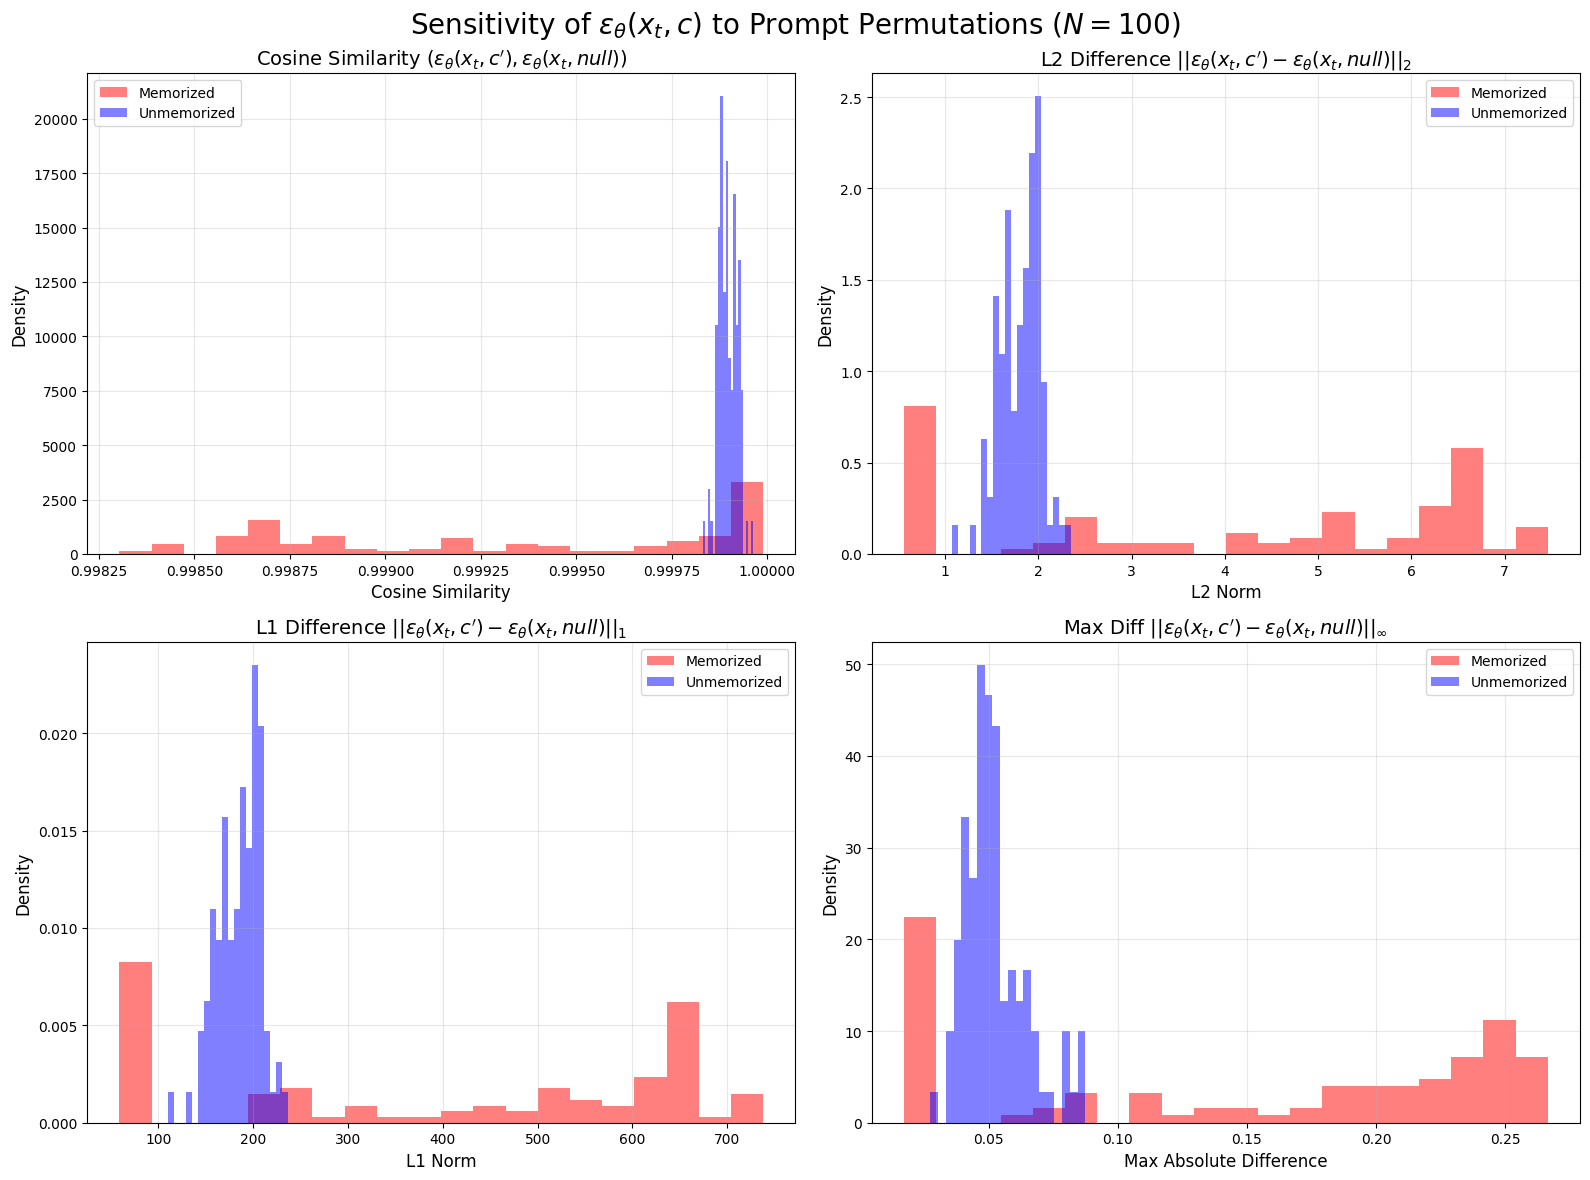


=== Summary (Mean Values) ===
Metric          | Memorized    | Unmemorized  | Ratio (M/U)
-------------------------------------------------------
cond_cos_sim    | 0.99933      | 0.99990      | 1.00      
cond_l2_diff    | 3.97380      | 1.81011      | 2.20      
cond_l1_diff    | 395.46902    | 185.51794    | 2.13      
cond_max_diff   | 0.15132      | 0.05232      | 2.89      


In [40]:
# Visualization
metrics_info = {
    "cond_cos_sim": {
        "title": r"Cosine Similarity $(\epsilon_\theta(x_t, c'), \epsilon_\theta(x_t, null))$",
        "xlabel": "Cosine Similarity"
    },
    "cond_l2_diff": {
        "title": r"L2 Difference $||\epsilon_\theta(x_t, c') - \epsilon_\theta(x_t, null)||_2$",
        "xlabel": "L2 Norm"
    },
    "cond_l1_diff": {
        "title": r"L1 Difference $||\epsilon_\theta(x_t, c') - \epsilon_\theta(x_t, null)||_1$",
        "xlabel": "L1 Norm"
    },
    "cond_max_diff": {
        "title": r"Max Diff $||\epsilon_\theta(x_t, c') - \epsilon_\theta(x_t, null)||_\infty$",
        "xlabel": "Max Absolute Difference"
    }
}

metrics_to_plot = list(metrics_info.keys())
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx]
    info = metrics_info[metric]
    
    ax.hist(mem_stats[metric], bins=20, alpha=0.5, label='Memorized', density=True, color='red')
    ax.hist(unmem_stats[metric], bins=20, alpha=0.5, label='Unmemorized', density=True, color='blue')
    
    ax.set_title(info["title"], fontsize=14)
    ax.set_xlabel(info["xlabel"], fontsize=12)
    ax.set_ylabel("Density", fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle(r"Sensitivity of $\epsilon_\theta(x_t, c)$ to Prompt Permutations ($N=100$)", fontsize=20)
plt.tight_layout()
plt.show()

# Summary Table
print("\n=== Summary (Mean Values) ===")
print(f"{'Metric':<15} | {'Memorized':<12} | {'Unmemorized':<12} | {'Ratio (M/U)':<10}")
print("-" * 55)
for m in metrics_to_plot:
    m_val = np.mean(mem_stats[m])
    u_val = np.mean(unmem_stats[m])
    ratio = m_val / u_val if u_val != 0 else 0
    print(f"{m:<15} | {m_val:<12.5f} | {u_val:<12.5f} | {ratio:<10.2f}")

# Jacobian Sensitivity Analysis

이전 실험에서는 단어 순서 변경(Discrete Permutation)에 따른 변화를 측정했습니다. 
여기서는 PyTorch의 Autograd를 사용하여 **Text Embedding Vector** $\mathbf{c}$에 대한 **Noise Prediction** $\epsilon_\theta(x_t, \mathbf{c})$의 **Jacobian Norm**을 직접 계산합니다.

$$ \text{Sensitivity} = || \nabla_\mathbf{c} \epsilon_\theta(x_t, \mathbf{c}) ||_F $$

Jacobian Norm이 클수록 입력 임베딩의 미세한 변화에 대해 출력(Noise Prediction)이 민감하게 반응함을 의미하며, 이는 "Sharp Minima" 가설을 뒷받침하는 근거가 될 수 있습니다.

In [41]:
import torch

def get_jacobian_norm(pipe, prompt, generator=None, num_projections=1):
    """
    Estimates the Frobenius norm of the Jacobian of the UNet output w.r.t. the prompt embeddings.
    Uses Hutchinson's trace estimator / Jacobian-Vector Product.
    Explicity handles dtype to avoid Float vs Half errors.
    """
    device = pipe.device
    dtype = pipe.unet.dtype # Use UNet's dtype as reference
    
    # 1. Get Text Embeddings
    # Tokenize
    text_inputs = pipe.tokenizer(
        prompt,
        padding="max_length",
        max_length=pipe.tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )
    text_input_ids = text_inputs.input_ids.to(device)
    
    # Encode (Detach first, then require grad)
    with torch.no_grad():
        prompt_embeds = pipe.text_encoder(text_input_ids)[0]
        prompt_embeds = prompt_embeds.to(dtype=dtype) # Ensure consistent dtype
    
    # We want gradient w.r.t these embeddings
    prompt_embeds.requires_grad_(True)
    
    # 2. Prepare Inputs for UNet
    # Fixed timestep (e.g., 999 for T) and random latents
    height = pipe.unet.config.sample_size * pipe.vae_scale_factor
    width = pipe.unet.config.sample_size * pipe.vae_scale_factor
    num_channels_latents = pipe.unet.config.in_channels
    
    latents = torch.randn(
        (1, num_channels_latents, height // 8, width // 8),
        device=device,
        generator=generator,
        dtype=dtype # Ensure latents match model dtype
    )
    
    # Use a large timestep to see sensitivity of initial noise prediction
    t = torch.tensor([999], device=device).long()
    
    # 3. UNet Forward
    # Pass embeddings explicitly
    noise_pred = pipe.unet(latents, t, encoder_hidden_states=prompt_embeds).sample
    
    # 4. Jacobian Norm Estimation
    total_sq_norm = 0.0
    
    for _ in range(num_projections):
        # Random vector v must match noise_pred dtype
        v = torch.randn_like(noise_pred)
        
        # autograd.grad
        grads = torch.autograd.grad(
            outputs=noise_pred,
            inputs=prompt_embeds,
            grad_outputs=v,
            retain_graph=True,
            create_graph=False,
            only_inputs=True
        )[0]
        
        total_sq_norm += grads.pow(2).sum().item()
        
    # Average and Sqrt
    jacobian_norm = (total_sq_norm / num_projections) ** 0.5
    
    # Cleanup
    prompt_embeds.requires_grad_(False)
    return jacobian_norm

# Calculate Jacobian Norms
mem_jacobians = []
unmem_jacobians = []
num_samples = 50
gen = torch.Generator(device=pipe.device).manual_seed(42)

print(f"Calculating Jacobian Norms for {num_samples} prompts each...")
print("Processing Memorized Prompts...")
for p in memorized_prompts[:num_samples]:
    try:
        val = get_jacobian_norm(pipe, p, gen)
        mem_jacobians.append(val)
    except Exception as e:
        print(f"Error with prompt {p}: {e}")

print("Processing Unmemorized Prompts...")
for p in unmemorized_prompts[:num_samples]:
    try:
        val = get_jacobian_norm(pipe, p, gen)
        unmem_jacobians.append(val)
    except Exception as e:
        print(f"Error with prompt {p}: {e}")

print(f"Done. Memorized: {len(mem_jacobians)}, Unmemorized: {len(unmem_jacobians)}")

Calculating Jacobian Norms for 50 prompts each...
Processing Memorized Prompts...
Processing Unmemorized Prompts...
Done. Memorized: 50, Unmemorized: 50


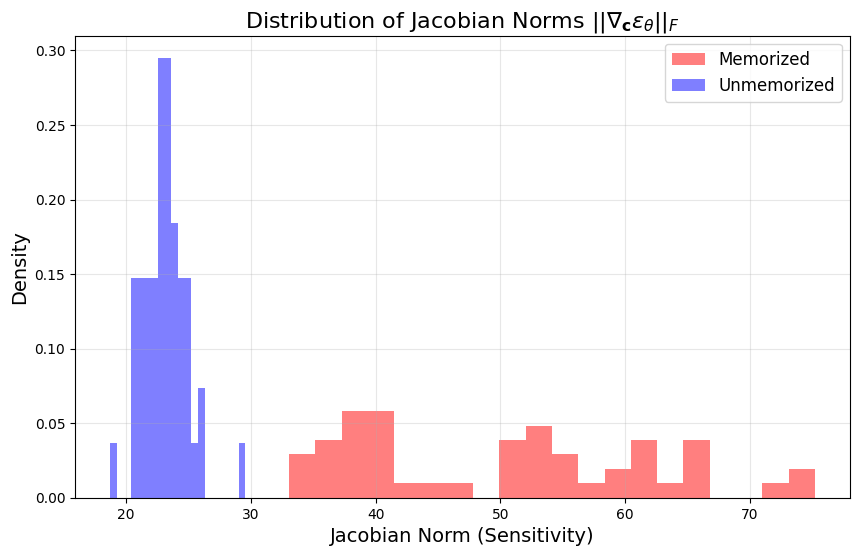


=== Jacobian Norm Summary ===
Memorized Mean:   50.2803
Unmemorized Mean: 23.0906
Ratio (M/U):      2.18
(Filtered 1 invalid from Memorized, 0 from Unmemorized)


In [42]:
# Visualization: Jacobian Norm Distribution
import numpy as np
import matplotlib.pyplot as plt

# Filter discrete infinity or NaN values for safer plotting
def filter_valid(data):
    arr = np.array(data)
    return arr[np.isfinite(arr)]

clean_mem_j = filter_valid(mem_jacobians)
clean_unmem_j = filter_valid(unmem_jacobians)

plt.figure(figsize=(10, 6))
plt.hist(clean_mem_j, bins=20, alpha=0.5, label='Memorized', density=True, color='red')
plt.hist(clean_unmem_j, bins=20, alpha=0.5, label='Unmemorized', density=True, color='blue')

plt.title(r"Distribution of Jacobian Norms $|| \nabla_\mathbf{c} \epsilon_\theta ||_F$", fontsize=16)
plt.xlabel(r"Jacobian Norm (Sensitivity)", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

# Summary Statistics
mean_mem_j = np.mean(clean_mem_j) if len(clean_mem_j) > 0 else 0
mean_unmem_j = np.mean(clean_unmem_j) if len(clean_unmem_j) > 0 else 0
ratio_j = mean_mem_j / mean_unmem_j if mean_unmem_j != 0 else 0

print("\n=== Jacobian Norm Summary ===")
print(f"Memorized Mean:   {mean_mem_j:.4f}")
print(f"Unmemorized Mean: {mean_unmem_j:.4f}")
print(f"Ratio (M/U):      {ratio_j:.2f}")
print(f"(Filtered {len(mem_jacobians) - len(clean_mem_j)} invalid from Memorized, {len(unmem_jacobians) - len(clean_unmem_j)} from Unmemorized)")

# Conditional Output Set Analysis (Diversity & Spread)

이전 분석이 'Unconditional Noise'라는 고정점에서의 거리를 측정했다면, 이번에는 **생성된 Conditional Noise 벡터들의 집합(Set) 자체의 분포**를 분석합니다.

하나의 프롬프트 $c$에 대해 여러 변형 $c_1, ..., c_N$을 가했을 때, 생성된 노이즈 벡터들 $\{\epsilon_\theta(x_t, c_i)\}_{i=1}^N$이 공간 상에서 얼마나 퍼져있는지(**Spread**)를 측정합니다.

- **Centroid**: $\bar{\epsilon} = \frac{1}{N} \sum_{i=1}^N \epsilon_i$
- **Spread (Diversity)**: $\frac{1}{N} \sum_{i=1}^N || \epsilon_i - \bar{\epsilon} ||_2$

Spread가 클수록 해당 프롬프트 영역의 Loss Landscape가 불안정하거나(Sharp), 입력 변화에 따라 출력이 크게 달라짐을 의미합니다.

# CLIP Dual Embedding Sensitivity Analysis

CLIP Text Encoder는 두 가지 형태의 출력을 제공합니다:
1. **Pooled Output** (Global): 문장 전체를 요약한 벡터 ($$ \mathbb{R}^{768} $$). Image-Text Similarity 학습에 사용됩니다.
2. **Last Hidden State** (Sequence): 토큰별 맥락 벡터 시퀀스 ($$ \mathbb{R}^{77 \times 768} $$). Diffusion Model의 Cross-Attention Condition으로 사용됩니다.

Memorization이 CLIP 내부의 어떤 표현(Representation)의 민감도와 관련이 있는지 확인하기 위해 두 가지 Jacobian을 모두 계산합니다.

$$ J_{pooled} = || \nabla_{\text{inputs}} \text{CLIP}_{pooled} ||_F $$
$$ J_{seq} = || \nabla_{\text{inputs}} \text{CLIP}_{seq} ||_F $$

Calculating CLIP Dual Jacobians (Stable Mode)...
Processing Memorized...
Processing Unmemorized...

=== CLIP Jacobian Summary ===
                J_Pooled         J_Seq
Type                                  
Memorized    1711.320240  22060.687838
Unmemorized   928.296341  14302.839116


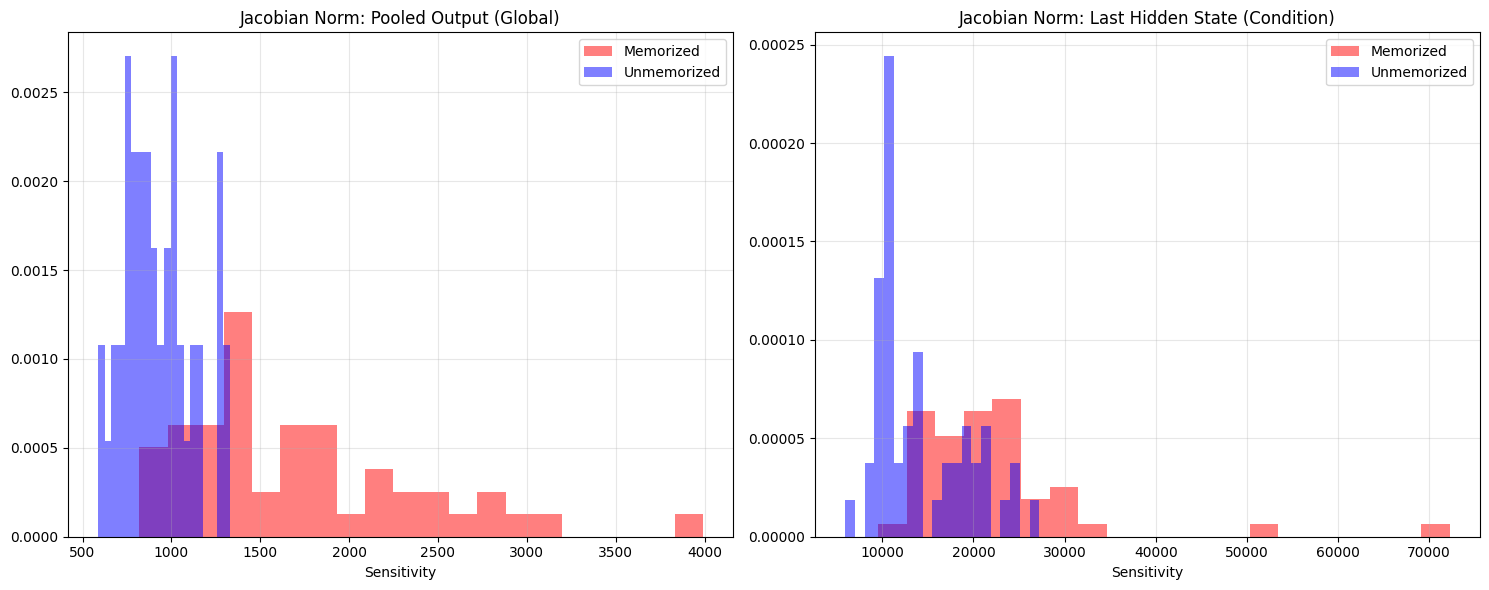

In [60]:

def get_clip_jacobians(pipe, prompt, num_projections=1):
    """
    Calculates Jacobian Norms for BOTH Pooled and Sequence output,
    using a manual forward pass.
    Fix: Uses transformers.models.clip.modeling_clip._create_4d_causal_attention_mask
    Fix: Uses float32 for accumulation to avoid Inf/NaN in fp16
    """
    device = pipe.device
    dtype = pipe.unet.dtype
    
    # Imports needed for manual mask creation
    from transformers.modeling_attn_mask_utils import _create_4d_causal_attention_mask, _prepare_4d_attention_mask
    
    # 1. Prepare Inputs
    text_input = pipe.tokenizer(
        prompt,
        padding="max_length",
        max_length=pipe.tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt"
    )
    input_ids = text_input.input_ids.to(device)
    attention_mask = text_input.attention_mask.to(device)
    
    # Access sub-modules
    text_model = pipe.text_encoder.text_model
    embeddings_module = text_model.embeddings
    encoder_module = text_model.encoder
    final_layer_norm = text_model.final_layer_norm
    
    # 2. Get Initial Embeddings
    with torch.no_grad():
        word_embeddings = embeddings_module.token_embedding(input_ids)
        
    inputs_embeds = word_embeddings.detach().to(dtype=dtype).requires_grad_(True)
    
    input_shape = input_ids.size()
    bsz, seq_len = input_shape
    
    # 3. Manual Forward Pass
    
    # A. Embeddings (Add Position)
    hidden_states = embeddings_module(input_ids=None, position_ids=None, inputs_embeds=inputs_embeds)
    
    # B. Create Masks
    causal_attention_mask = _create_4d_causal_attention_mask(
        input_shape, hidden_states.dtype, device=hidden_states.device
    )
    
    if attention_mask is not None:
        attention_mask_expanded = _prepare_4d_attention_mask(attention_mask, hidden_states.dtype)
    else:
        attention_mask_expanded = None
        
    # C. Encoder
    encoder_outputs = encoder_module(
        inputs_embeds=hidden_states,
        attention_mask=attention_mask_expanded,
        causal_attention_mask=causal_attention_mask,
        output_hidden_states=True
    )
    
    last_hidden_state = encoder_outputs.last_hidden_state
    last_hidden_state = final_layer_norm(last_hidden_state)
    
    # D. Pooling
    eos_token_id = pipe.text_encoder.config.eos_token_id
    if eos_token_id is None:
         eos_token_id = 49407
         
    if eos_token_id == 2:
        pooled_output = last_hidden_state[
            torch.arange(bsz, device=device),
            input_ids.to(dtype=torch.int, device=device).argmax(dim=-1),
        ]
    else:
        pooled_output = last_hidden_state[
            torch.arange(bsz, device=device),
            input_ids.argmax(dim=-1), 
        ]
        
    # 4. Jacobian Estimation (Float32 Accumulation)
    def estimate_j_norm(target_tensor):
        total_sq = 0.0
        for _ in range(num_projections):
            v = torch.randn_like(target_tensor)
            grads = torch.autograd.grad(
                target_tensor, 
                inputs_embeds, 
                grad_outputs=v, 
                retain_graph=True, 
                create_graph=False
            )[0]
            # CAST TO FLOAT32 to avoid overflow/underflow
            total_sq += grads.float().pow(2).sum().item()
        return (total_sq / num_projections) ** 0.5

    j_pooled = estimate_j_norm(pooled_output)
    j_seq = estimate_j_norm(last_hidden_state)
    
    return j_pooled, j_seq

# === Experiment Execution ===
print("Calculating CLIP Dual Jacobians (Stable Mode)...")
results_clip = []
num_samples = 50

for p_list, label, color in [(memorized_prompts, "Memorized", "red"), (unmemorized_prompts, "Unmemorized", "blue")]:
    print(f"Processing {label}...")
    count = 0
    for p in p_list:
        if count >= num_samples: break
        try:
            jp, js = get_clip_jacobians(pipe, p)
            results_clip.append({
                "Type": label,
                "Prompt": p,
                "J_Pooled": jp,
                "J_Seq": js
            })
            count += 1
        except Exception as e:
            # print(f"Error {p}: {e}")
            pass

# === Analysis & Properties ===
df_clip = pd.DataFrame(results_clip)
print("\n=== CLIP Jacobian Summary ===")

# Clean Data (Remove Inf/Nan)
df_clip = df_clip.replace([np.inf, -np.inf], np.nan).dropna(subset=["J_Pooled", "J_Seq"])

if not df_clip.empty:
    print(df_clip.groupby("Type")[["J_Pooled", "J_Seq"]].mean())

    # === Visualization ===
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # 1. Pooled Output
    for label, color in [("Memorized", "red"), ("Unmemorized", "blue")]:
        subset = df_clip[df_clip["Type"] == label]
        if not subset.empty:
            axes[0].hist(subset["J_Pooled"], bins=20, alpha=0.5, label=label, density=True, color=color)

    axes[0].set_title("Jacobian Norm: Pooled Output (Global)")
    axes[0].set_xlabel("Sensitivity")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # 2. Sequence Output
    for label, color in [("Memorized", "red"), ("Unmemorized", "blue")]:
        subset = df_clip[df_clip["Type"] == label]
        if not subset.empty:
            axes[1].hist(subset["J_Seq"], bins=20, alpha=0.5, label=label, density=True, color=color)

    axes[1].set_title("Jacobian Norm: Last Hidden State (Condition)")
    axes[1].set_xlabel("Sensitivity")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print("No valid results to plot after removing Infs.")


In [61]:
def analyze_output_set_properties(pipe, base_prompt, num_variations=30, generator=None):
    """
    Generates variations of a prompt and measures the geometrical properties 
    of the resulting set of conditional noise vectors.
    Robust to pipe return types and FP16/32 mismatches.
    """
    device = pipe.device
    dtype = pipe.unet.dtype # Ensure consistent dtype

    # 1. Generate Variations
    words = base_prompt.split()
    variations = []
    variations.append(base_prompt)
    
    for _ in range(num_variations - 1):
        if len(words) > 1:
            p_words = words.copy()
            random.shuffle(p_words)
            variations.append(" ".join(p_words))
        else:
            variations.append(base_prompt)
            
    # 2. Get Cond Noise Vectors
    vectors = []
    
    for txt in variations:
        cond = None
        try:
            # Attempt 1: Call pipe directly if it supports return_dict=True and output_type=None
            # But FirstStepAnalysisPipeline might not support output_type arg if not implemented.
            # Let's rely on manual forward pass which we control completely.
            # This avoids the pipeline wrapper ambiguity entirely.
            raise NotImplementedError("Force manual bypass")
        except:
            # Fallback / Primary Method: Manual UNet Forward
            try:
                # Tokenize
                text_input = pipe.tokenizer(
                    txt,
                    padding="max_length",
                    max_length=pipe.tokenizer.model_max_length,
                    truncation=True,
                    return_tensors="pt"
                )
                
                with torch.no_grad():
                    embeds = pipe.text_encoder(text_input.input_ids.to(device))[0]
                    embeds = embeds.to(dtype=dtype) # Cast to correct dtype

                # Prepare Latents
                height = pipe.unet.config.sample_size * pipe.vae_scale_factor
                width = pipe.unet.config.sample_size * pipe.vae_scale_factor
                # Re-seed generator for consistency if needed, but here we want randomness across calls?
                # Actually, we want same latent noise for different text variations to isolate text effect.
                # So generator should be same or reset.
                # We use the passed generator which advances state. 
                # To compare text effect fairly, we should probably FIX the initial noise for all variations.
                # But the signature takes 'generator'. Let's use a temporary local generator seeded once.
                local_gen = torch.Generator(device=device).manual_seed(42)
                
                latents = torch.randn(
                    (1, pipe.unet.config.in_channels, height // 8, width // 8),
                    device=device,
                    generator=local_gen,
                    dtype=dtype # Cast to correct dtype
                )
                
                t = torch.tensor([999], device=device).long()
                
                # UNet Forward
                # Cond vector
                cond_tensor = pipe.unet(latents, t, encoder_hidden_states=embeds).sample
                cond = cond_tensor
                
            except Exception as e:
                print(f"Manual forward failed for '{txt[:15]}...': {e}")
                continue # Skip this variation

        if cond is not None:
            vectors.append(cond.detach().cpu().float()) # Convert to float32 for stats
        
    if not vectors:
        return {"spread": 0.0, "avg_norm": 0.0}
        
    stack = torch.stack(vectors)
    N = stack.shape[0]
    # If N=1 (only original), spread is 0.
    
    stack_flat = stack.view(N, -1)
    
    centroid = stack_flat.mean(dim=0, keepdim=True)
    dists = torch.norm(stack_flat - centroid, p=2, dim=1)
    spread = dists.mean().item()
    
    norms = torch.norm(stack_flat, p=2, dim=1)
    avg_norm = norms.mean().item()
    
    return {
        "spread": spread,
        "avg_norm": avg_norm
    }

# Run Set Analysis Loop
mem_set_stats = {"spread": [], "avg_norm": []}
unmem_set_stats = {"spread": [], "avg_norm": []}
num_samples_set = 50
variations_per_prompt = 30
gen_dummy = torch.Generator(device=pipe.device).manual_seed(42)

print(f"Analyzing Output Set Properties for {num_samples_set} prompts...")

print("Processing Memorized...")
for p in memorized_prompts[:num_samples_set]:
    res = analyze_output_set_properties(pipe, p, variations_per_prompt, gen_dummy)
    # Only add if valid (non-zero or we accept 0 spread for single items)
    # If avg_norm is 0, it likely failed completely
    if res['avg_norm'] > 0:
        mem_set_stats["spread"].append(res["spread"])
        mem_set_stats["avg_norm"].append(res["avg_norm"])
        
print("Processing Unmemorized...")
for p in unmemorized_prompts[:num_samples_set]:
    res = analyze_output_set_properties(pipe, p, variations_per_prompt, gen_dummy)
    if res['avg_norm'] > 0:
        unmem_set_stats["spread"].append(res["spread"])
        unmem_set_stats["avg_norm"].append(res["avg_norm"])

print("Set Analysis Done.")

Analyzing Output Set Properties for 50 prompts...
Processing Memorized...
Processing Unmemorized...
Set Analysis Done.


/tmp/ipykernel_762347/2704470983.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_to_plot, labels=['Memorized', 'Unmemorized'], patch_artist=True,


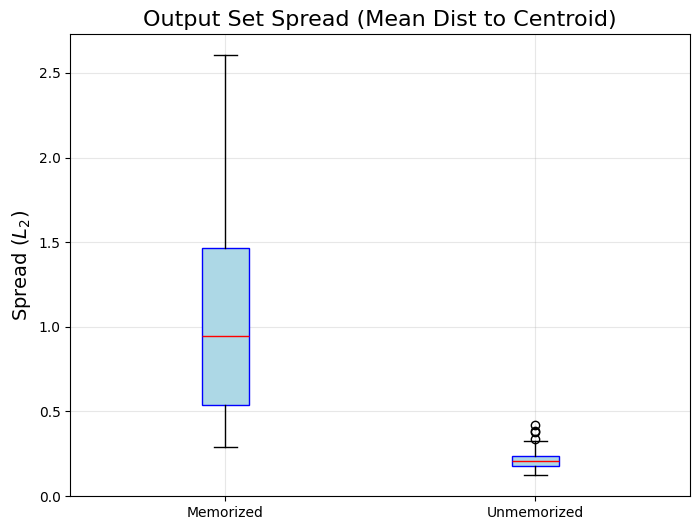


=== Output Set Spread Summary ===
Memorized Mean Spread:   1.1065
Unmemorized Mean Spread: 0.2199
Ratio (M/U):             5.03


In [44]:
# Visualization: Output Set Spread
fig, ax = plt.subplots(figsize=(8, 6))

data_to_plot = [mem_set_stats["spread"], unmem_set_stats["spread"]]
ax.boxplot(data_to_plot, labels=['Memorized', 'Unmemorized'], patch_artist=True, 
           boxprops=dict(facecolor='lightblue', color='blue'),
           medianprops=dict(color='red'))

ax.set_title(r"Output Set Spread (Mean Dist to Centroid)", fontsize=16)
ax.set_ylabel(r"Spread ($L_2$)", fontsize=14)
ax.grid(True, alpha=0.3)

plt.show()

# Summary
m_spread = np.mean(mem_set_stats["spread"])
u_spread = np.mean(unmem_set_stats["spread"])
print("\n=== Output Set Spread Summary ===")
print(f"Memorized Mean Spread:   {m_spread:.4f}")
print(f"Unmemorized Mean Spread: {u_spread:.4f}")
print(f"Ratio (M/U):             {m_spread/u_spread:.2f}")

# Embedding Space Noise Sensitivity Analysis

이전 실험에서는 단어 순서를 섞는(Discrete) 변화를 주었다면, 이번에는 **Text Embedding Space에서 직접 Gaussian Noise를 주입하는(Continuous) 방식**으로 민감도를 측정합니다.

- **Method**:
  1. Prompt Embedding $\mathbf{c}$ 추출
  2. Noise 주입: $\mathbf{c}' = \mathbf{c} + \sigma \cdot \mathbf{z} \quad (\mathbf{z} \sim \mathcal{N}(0, I))$
  3. Output 비교: $|| \epsilon_\theta(\mathbf{c}) - \epsilon_\theta(\mathbf{c}') ||_2$

Memorized Prompt가 Sharp Minima에 위치한다면, 동일한 크기의 Embedding Noise $\sigma$에 대해 더 큰 Output 변화를 보일 것입니다.

In [45]:
def analyze_embedding_noise_sensitivity(pipe, prompt, noise_scale=1e-2, generator=None):
    """
    Adds Gaussian noise to text embeddings and measures output sensitivity.
    """
    device = pipe.device
    dtype = pipe.unet.dtype
    
    # 1. Get Base Embedding
    text_input = pipe.tokenizer(
        prompt,
        padding="max_length",
        max_length=pipe.tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt"
    )
    
    with torch.no_grad():
        base_embeds = pipe.text_encoder(text_input.input_ids.to(device))[0].to(dtype=dtype)
        
        # 2. Create Noise Vector
        # Random noise with same shape as embedding
        # We use a local generator for the noise added to TEXT to vary it per call if needed,
        # or we could make it consistent. Since we want to test sensitivity to ANY direction,
        # random is fine.
        noise = torch.randn_like(base_embeds) * noise_scale
        perturbed_embeds = base_embeds + noise
    
        # 3. Prepare Latents (Fixed for both)
        height = pipe.unet.config.sample_size * pipe.vae_scale_factor
        width = pipe.unet.config.sample_size * pipe.vae_scale_factor
        
        # Important: Use fixed latents for fair comparison
        if generator is None:
             generator = torch.Generator(device=device).manual_seed(42)
             
        latents = torch.randn(
            (1, pipe.unet.config.in_channels, height // 8, width // 8),
            device=device,
            generator=generator,
            dtype=dtype
        )
        
        t = torch.tensor([999], device=device).long()
        
        # 4. Forward Pass
        # Base Output
        res_base = pipe.unet(latents, t, encoder_hidden_states=base_embeds).sample
        
        # Perturbed Output
        res_pert = pipe.unet(latents, t, encoder_hidden_states=perturbed_embeds).sample
        
        # 5. Measure Difference
        # Relative L2 Difference
        diff = torch.norm(res_base - res_pert, p=2).item()
        base_norm = torch.norm(res_base, p=2).item()
        
        rel_diff = diff / base_norm if base_norm > 1e-6 else 0.0
        
        return rel_diff


# Run Analysis
noise_level = 0.1 # Defines the radius of perturbation ball
mem_emb_sens = []
unmem_emb_sens = []
num_samples = 50
gen = torch.Generator(device=pipe.device).manual_seed(42)

print(f"Analyzing Embedding Noise Sensitivity (sigma={noise_level}) for {num_samples} prompts...")

print("Processing Memorized...")
for p in memorized_prompts[:num_samples]:
    try:
        val = analyze_embedding_noise_sensitivity(pipe, p, noise_level, gen)
        mem_emb_sens.append(val)
    except Exception as e:
        print(f"Skipping {p[:10]}...: {e}")

print("Processing Unmemorized...")
for p in unmemorized_prompts[:num_samples]:
    try:
        val = analyze_embedding_noise_sensitivity(pipe, p, noise_level, gen)
        unmem_emb_sens.append(val)
    except Exception as e:
        print(f"Skipping {e}")
        
print(f"Done. Mem: {len(mem_emb_sens)}, Unmem: {len(unmem_emb_sens)}")

Analyzing Embedding Noise Sensitivity (sigma=0.1) for 50 prompts...
Processing Memorized...
Processing Unmemorized...
Done. Mem: 50, Unmem: 50


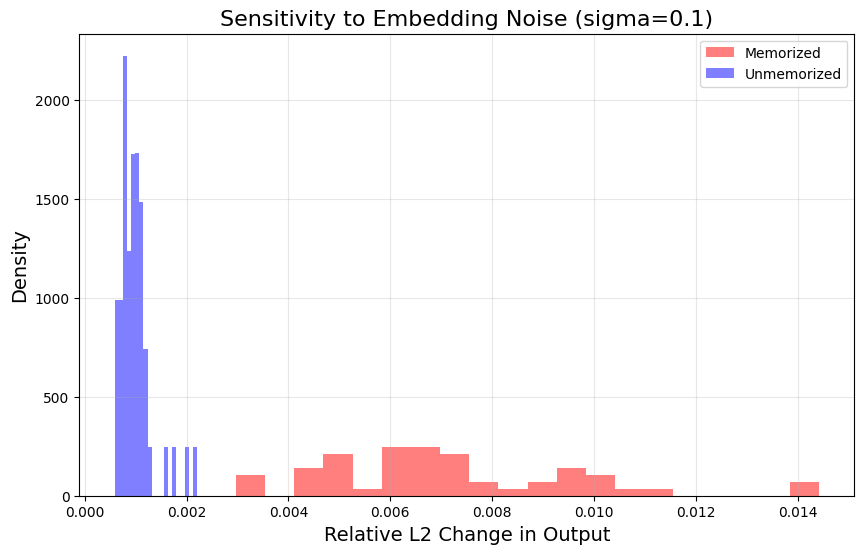

Mean Sensitivity (Mem):   0.0072
Mean Sensitivity (Unmem): 0.0010


In [46]:
# Visualization: Embedding Sensitivity
plt.figure(figsize=(10, 6))

# Filter NaN/Inf just in case
clean_mem = [x for x in mem_emb_sens if np.isfinite(x)]
clean_unmem = [x for x in unmem_emb_sens if np.isfinite(x)]

plt.hist(clean_mem, bins=20, alpha=0.5, label='Memorized', density=True, color='red')
plt.hist(clean_unmem, bins=20, alpha=0.5, label='Unmemorized', density=True, color='blue')

plt.title(f"Sensitivity to Embedding Noise (sigma={noise_level})", fontsize=16)
plt.xlabel("Relative L2 Change in Output", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Mean Sensitivity (Mem):   {np.mean(clean_mem):.4f}")
print(f"Mean Sensitivity (Unmem): {np.mean(clean_unmem):.4f}")

# Semantic Sensitivity Analysis: Word Substitution

이 섹션에서는 단순 순서 변경이 아닌, **단어 자체를 변경(Substitution)**했을 때의 민감도를 분석합니다.

1. **Synonym Replacement (유사 변경)**: 명사를 유의어(Synonym)로 교체합니다. 의미가 비슷하므로 출력 변화가 작아야 합니다.
2. **Random Replacement (상이 변경)**: 명사를 의미가 다른 랜덤한 명사로 교체합니다. 의미가 다르므로 출력 변화가 커야 합니다.

Memorized Prompt가 과적합되어 있다면, 유의어 교체에도 민감하게 반응할 수 있습니다.

In [47]:
import nltk
from nltk.corpus import wordnet
import random

# Ensure NLTK resources
try:
    nltk.data.find('corpora/wordnet.zip')
    nltk.data.find('taggers/averaged_perceptron_tagger.zip')
    nltk.data.find('tokenizers/punkt.zip')
except LookupError:
    nltk.download('wordnet')
    nltk.download('averaged_perceptron_tagger')
    nltk.download('punkt')
    nltk.download('punkt_tab')
    nltk.download('averaged_perceptron_tagger_eng')

# Helper to find nouns
def get_nouns(text):
    tokens = nltk.word_tokenize(text)
    tagged = nltk.pos_tag(tokens)
    # NN, NNS, NNP, NNPS are nouns
    return [word for word, pos in tagged if pos.startswith('NN')]

# Helper to get synonyms
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            # Filter out multi-word synonyms or same word
            if '_' not in lemma.name() and lemma.name().lower() != word.lower():
                synonyms.add(lemma.name())
    return list(synonyms)

# Helper to get random common nouns (simple list for demonstration)
common_nouns = [
    "apple", "car", "dog", "cat", "house", "tree", "computer", "phone", 
    "book", "pen", "mountain", "river", "ocean", "star", "planet", 
    "city", "friend", "idea", "time", "money", "music", "art"
]

def generate_substitution_variations(text, mode='synonym', max_variations=100):
    tokens = nltk.word_tokenize(text)
    tagged = nltk.pos_tag(tokens)
    
    variations = set()
    
    # Identify indices of nouns
    noun_indices = [i for i, (word, pos) in enumerate(tagged) if pos.startswith('NN')]
    
    if not noun_indices:
        return []
        
    # Attempt to generate variations
    attempts = 0
    while len(variations) < max_variations and attempts < max_variations * 5:
        attempts += 1
        # Pick a random noun to replace
        idx = random.choice(noun_indices)
        target_word = tokens[idx]
        
        replacement = None
        if mode == 'synonym':
            syns = get_synonyms(target_word)
            if syns:
                replacement = random.choice(syns)
        else: # mode == 'random'
            replacement = random.choice(common_nouns)
            
        if replacement:
            new_tokens = tokens.copy()
            new_tokens[idx] = replacement
            # Simple join, ignoring punctuation spacing correctness for embedding
            new_text = " ".join(new_tokens).replace(" .", ".").replace(" ,", ",")
            variations.add(new_text)
            
    return list(variations)

# Analysis Wrapper
def analyze_substitution_sensitivity(pipe, prompt, mode='synonym', max_vars=20, generator=None):
    # 1. Base Output
    # Manual forward to control generator
    height = pipe.unet.config.sample_size * pipe.vae_scale_factor
    width = pipe.unet.config.sample_size * pipe.vae_scale_factor
    latents = torch.randn((1, pipe.unet.config.in_channels, height // 8, width // 8), 
                          device=pipe.device, generator=generator, dtype=pipe.unet.dtype)
    t = torch.tensor([999], device=pipe.device).long()
    
    # Get Base Cond
    tokens_base = pipe.tokenizer(prompt, padding="max_length", max_length=pipe.tokenizer.model_max_length, truncation=True, return_tensors="pt")
    with torch.no_grad():
        embeds_base = pipe.text_encoder(tokens_base.input_ids.to(pipe.device))[0].to(dtype=pipe.unet.dtype)
        res_base = pipe.unet(latents, t, encoder_hidden_states=embeds_base).sample
        
    # 2. Variations
    variations = generate_substitution_variations(prompt, mode, max_vars)
    if not variations:
        return [], []
        
    diffs = []
    norm_base = torch.norm(res_base, p=2).item()
    
    for var_txt in variations:
        tokens_var = pipe.tokenizer(var_txt, padding="max_length", max_length=pipe.tokenizer.model_max_length, truncation=True, return_tensors="pt")
        with torch.no_grad():
            embeds_var = pipe.text_encoder(tokens_var.input_ids.to(pipe.device))[0].to(dtype=pipe.unet.dtype)
            res_var = pipe.unet(latents, t, encoder_hidden_states=embeds_var).sample
            
        diff = torch.norm(res_base - res_var, p=2).item()
        rel_diff = diff / norm_base if norm_base > 1e-6 else 0.0
        diffs.append(rel_diff)
        
    return diffs, variations

# Run Experiments
synonym_sens_mem = []
synonym_sens_unmem = []
random_sens_mem = []
random_sens_unmem = []

stored_synonym_vars = {}
stored_random_vars = {}

num_samples_sub = 50
max_vars_per_prompt = 20 # Mean over variations
gen = torch.Generator(device=pipe.device).manual_seed(42)

print("Running Substitution Analysis...")

for p in memorized_prompts[:num_samples_sub]:
    # 1. Synonym
    diffs, vars_txt = analyze_substitution_sensitivity(pipe, p, 'synonym', max_vars_per_prompt, gen)
    if diffs:
        synonym_sens_mem.extend(diffs)
        stored_synonym_vars[p] = vars_txt
    # 2. Random
    diffs, vars_txt = analyze_substitution_sensitivity(pipe, p, 'random', max_vars_per_prompt, gen)
    if diffs:
        random_sens_mem.extend(diffs)
        stored_random_vars[p] = vars_txt
        
for p in unmemorized_prompts[:num_samples_sub]:
    # 1. Synonym
    diffs, vars_txt = analyze_substitution_sensitivity(pipe, p, 'synonym', max_vars_per_prompt, gen)
    if diffs:
        synonym_sens_unmem.extend(diffs)
    # 2. Random
    diffs, vars_txt = analyze_substitution_sensitivity(pipe, p, 'random', max_vars_per_prompt, gen)
    if diffs:
        random_sens_unmem.extend(diffs)
        
print("Substitution Analysis Done.")

Running Substitution Analysis...


Substitution Analysis Done.


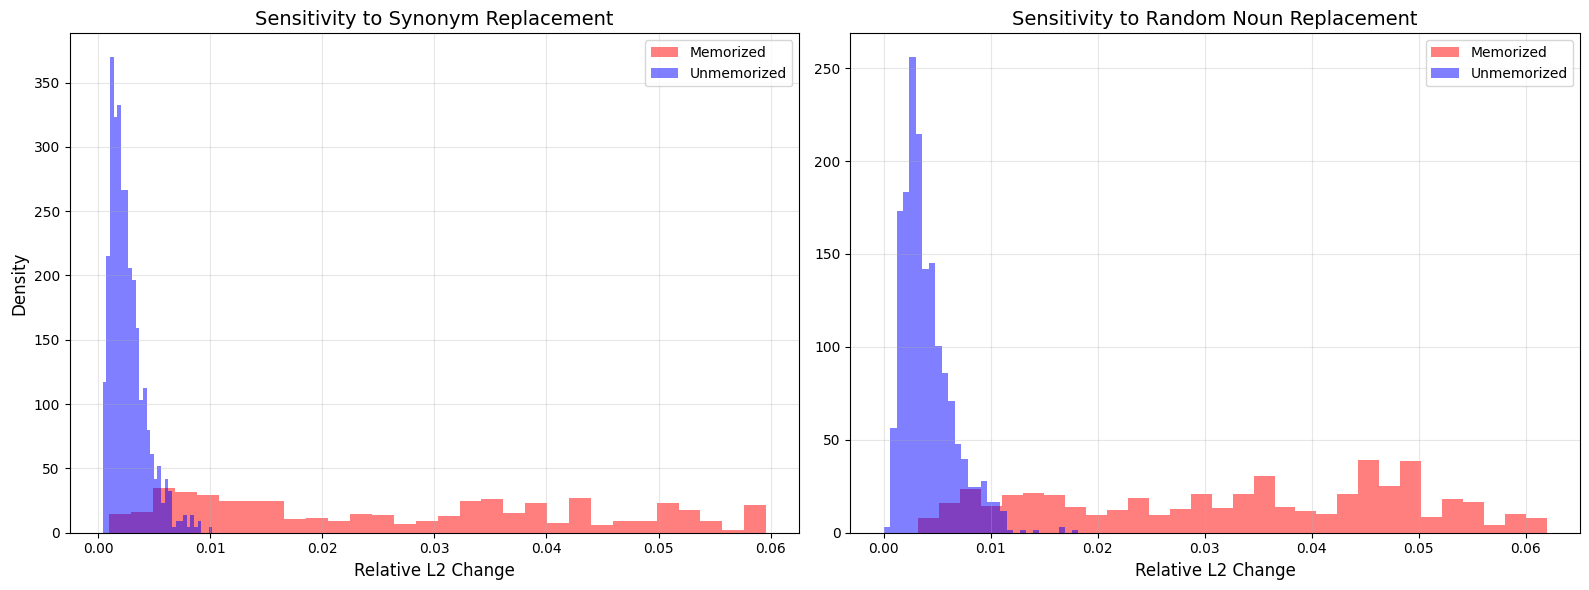

Mean Synonym Sens (M/U): 0.0272 / 0.0026
Mean Random Sens (M/U):  0.0327 / 0.0041

--- Example Synonym Variations (Memorized) ---
Original: The No Limits Business Woman Podcast
Variations: ['The No Limits byplay Woman Podcast', 'The No Limits Business charwoman Podcast', 'The No Limits job Woman Podcast']...


In [48]:
# Visualization: Substitution Sensitivity
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Synonym Plot
ax = axes[0]
ax.hist(synonym_sens_mem, bins=30, alpha=0.5, label='Memorized', density=True, color='red')
ax.hist(synonym_sens_unmem, bins=30, alpha=0.5, label='Unmemorized', density=True, color='blue')
ax.set_title("Sensitivity to Synonym Replacement", fontsize=14)
ax.set_xlabel("Relative L2 Change", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Random Plot
ax = axes[1]
ax.hist(random_sens_mem, bins=30, alpha=0.5, label='Memorized', density=True, color='red')
ax.hist(random_sens_unmem, bins=30, alpha=0.5, label='Unmemorized', density=True, color='blue')
ax.set_title("Sensitivity to Random Noun Replacement", fontsize=14)
ax.set_xlabel("Relative L2 Change", fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Mean Synonym Sens (M/U): {np.mean(synonym_sens_mem):.4f} / {np.mean(synonym_sens_unmem):.4f}")
print(f"Mean Random Sens (M/U):  {np.mean(random_sens_mem):.4f} / {np.mean(random_sens_unmem):.4f}")

print("\n--- Example Synonym Variations (Memorized) ---")
ex_key = list(stored_synonym_vars.keys())[0]
print(f"Original: {ex_key}")
print(f"Variations: {stored_synonym_vars[ex_key][:3]}...")